In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
#Mertics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline

c:\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
#Convert string timestamp format to timestamp
## https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
data = pd.read_csv("AirPassengers.csv", index_col= 'Month')
data.index = pd.to_datetime(data.index, format="%Y-%m")


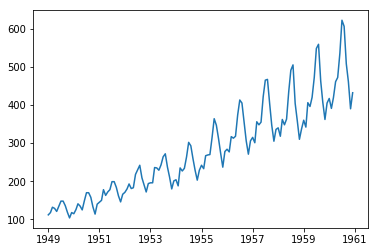

In [18]:
plt.plot(data)

### Decide Metric 

* **R squared**, coefficient of determination (in econometrics it can be interpreted as a percentage of variance explained by the model)
* **Mean Absolute Error** it is an interpretable metric because it has the same unit of measurement as the initial series
* Median Absolute Error, again an interpretable metric, particularly interesting because it is robust to outliers
* Mean Squared Error, most commonly used, gives higher penalty to big mistakes and vise versa
* Mean Squared Logarithmic Error, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends
* Mean Absolute Percentage Error, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management

In [19]:
#Calculate Mean Absolute Percentage
def mean_absolute_percentage_error(y_true, y_pred):
    return (100 * np.sum(np.abs(y_true - y_pred)))/len(y_true)
    

**Baseline 1 - Moving Average**
Follows that today is prediction the mean of the previous days value

In [22]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.mean(series[-n:])   # DF.tail can also be used in case of dataframes

moving_average(data, 10) # prediction for the last observed day (past 10 months)


#Passengers    490.6
dtype: float64

** Smoothing **
are designed to reduce or eliminate short-term volatility in data. A smoothed series is preferred to a non-smoothed one because it may capture changes in the direction of the economy better than the unadjusted series does
Besides seasonal adjustments, we can smooth the trends using moving averages. There is a downside to using a moving average to smooth a data series. As the calculation relies on historical data, some of the variable's timeliness is lost. “Weighted” moving average can be used, where the more current values of the variable are given more importance. Another way to reduce the reliance on past values is to calculate a “centered” moving average, where the current value is the middle value in a five-month average, with two lags and two leads.


In [28]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    #The wider the window,smoothing of the original time series to indicate trends. 
    #Pandas has an implementation available DataFrame.rolling(window).mean(). 
    #The wider the window - the smoother will be the trend. In the case of the very noisy data, which can be very often encountered in finance, this procedure can help to detect common patterns.
    rolling_mean = series.rolling(window=window).mean()
    #Confidenec Interval 
    if plot_intervals:
        
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
# https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

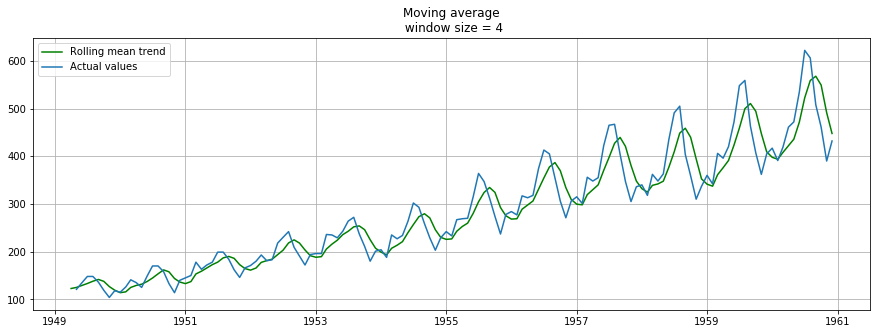

In [29]:
plotMovingAverage(data, 4)

